## Dataset Introduction
This dataset is based on the subset of users in the #nowplaying dataset who publish their #nowplaying tweets via Spotify. In principle, the dataset holds users, their playlists and the tracks contained in these playlists. 

The csv-file holding the dataset contains the following columns: 
"user_id", "artistname", "trackname", "playlistname"
, where
- **user_id** is a hash of the user's Spotify user name
- **artistname** is the name of the artist
- **trackname** is the title of the track and
- **playlistname** is the name of the playlist that contains this track.

## Goal of the project

_Can we suggest what to listen to next when presented with a number of songs?_

**The idea is to use the sequences of tracks that users have listened to in the past to predict what they might want to listen to next.**


We will build a sequential recommender system that having input a list of items, output the next items - Spotify is picking songs to suggest in your discover weekly playlist based on what songs you have listened to lately.. The model will learn from existing sequences (playlists by real users) how to continue extending an arbitrary new list. More generally, this task is also known as next event prediction (NEP). The modeling technique we picked will only leverage behavioral data in the form of interactions created by users when composing their playlists.


## Data Pre-processing


In [1]:
import pandas as pd
import random
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import powerlaw

import os
import json
import time
from random import choice
#!pip install scipy==1.11.0 
#from gensim.models import word2vec as w2v
from gensim.models.word2vec import Word2Vec


1. #### Read the CSV file

In [2]:
# Read the CSV file

p = 0.05  # to randomly select 5% of the rows
df_playlist_initial = pd.read_csv('spotify_dataset.csv', on_bad_lines='skip',  
                          skiprows=lambda i: i>0 and random.random() > p)


In [3]:
df_playlist_initial.describe()

user_id  "artistname"  "trackname"  \
count                             644586        642941       644583   
unique                             14540         77555       305678   
top     4398de6902abde3351347b048fcdc287     Daft Punk        Intro   
freq                               14573          1755          317   

        "playlistname"  
count           644516  
unique          100679  
top            Starred  
freq             67040

In [4]:
df_playlist_initial.head()

user_id                     "artistname"  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                  The Len Price 3   
1  9cc0cfd4d7d7885102480dd99e7a90d6                      The Coronas   
2  9cc0cfd4d7d7885102480dd99e7a90d6  Tom Petty And The Heartbreakers   
3  9cc0cfd4d7d7885102480dd99e7a90d6                Bruce Springsteen   
4  9cc0cfd4d7d7885102480dd99e7a90d6                Bruce Springsteen   

               "trackname"  "playlistname"  
0                 Pictures  HARD ROCK 2010  
1           San Diego Song  HARD ROCK 2010  
2            American Girl        IOW 2012  
3     Death To My Hometown        IOW 2012  
4  We Take Care Of Our Own        IOW 2012

In [5]:
# create a copy og the initial dataframe, incase you need reference back to the intial df
# Create a copy of the original DataFrame
df_playlist_modified = df_playlist_initial.copy()

#### Data Cleansing
##### let's get rid off the extra "" , and I prefer only 'artist' not 'artistname'

In [6]:
df_playlist_modified.columns = df_playlist_modified.columns.str.replace('"', "")
df_playlist_modified.columns = df_playlist_modified.columns.str.replace("name", "")
df_playlist_modified.columns = df_playlist_modified.columns.str.replace(" ", "")

In [7]:
df_playlist_modified.head()

user_id                           artist  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                  The Len Price 3   
1  9cc0cfd4d7d7885102480dd99e7a90d6                      The Coronas   
2  9cc0cfd4d7d7885102480dd99e7a90d6  Tom Petty And The Heartbreakers   
3  9cc0cfd4d7d7885102480dd99e7a90d6                Bruce Springsteen   
4  9cc0cfd4d7d7885102480dd99e7a90d6                Bruce Springsteen   

                     track        playlist  
0                 Pictures  HARD ROCK 2010  
1           San Diego Song  HARD ROCK 2010  
2            American Girl        IOW 2012  
3     Death To My Hometown        IOW 2012  
4  We Take Care Of Our Own        IOW 2012

#### What artists and songs are most popular?
1. It creates two Counter objects, artist_counter and song_counter, which count the occurrences of each artist and each track in the df_playlist_modified DataFrame.
2. artist_counter.most_common(20) and song_counter.most_common(20) display the top 20 most common artists and tracks respectively.

In [8]:
artist_counter = Counter(list(df_playlist_modified['artist']))
song_counter = Counter(list(df_playlist_modified['track']))
print("\nTop artists: {}\n".format(artist_counter.most_common(20)))
print("\nTop songs: {}\n".format(song_counter.most_common(20)))


Top artists: [('Daft Punk', 1755), ('Coldplay', 1720), (nan, 1645), ('Radiohead', 1600), ('The Rolling Stones', 1552), ('Kanye West', 1535), ('JAY Z', 1446), ('Eminem', 1424), ('Queen', 1404), ('David Bowie', 1368), ('Michael Jackson', 1310), ('U2', 1239), ('Muse', 1214), ('Rihanna', 1193), ('Arctic Monkeys', 1184), ('Pearl Jam', 1163), ('David Guetta', 1102), ('Foo Fighters', 1096), ('Bruce Springsteen', 1057), ('Bob Dylan', 1050)]


Top songs: [('Intro', 317), ('Home', 298), ('Closer', 195), ('Runaway', 183), ('Radioactive', 179), ('Stay', 163), ('Heaven', 152), ('Forever', 151), ('Crazy', 144), ('You', 144), ('Alive', 142), ('Wake Me Up', 141), ('Hold On', 141), ('Midnight City', 141), ('Kids', 139), ('Creep', 139), ('Animal', 138), ('Dreams', 136), ('Angel', 131), ('We Found Love', 130)]



#### visualize the distribution of tracks and artist in our dataset. 

1. Artists Histogram: Plots the number of times each artist appears in the playlists. The y-axis is on a logarithmic scale to handle the skewness in the data.
2. Songs Histogram: Plots the number of times each song appears in the playlists. Again, the y-axis is on a logarithmic scale.

In [9]:
def plot_distribution(artists, tracks, n_bins: int=50, outpath = './artist-track-dist.png'):
    """
    Plot distributions of tracks and artists in the final dataset.
    """
    import numpy as np
    from itertools import product
    import seaborn as sns
    sns.set_style()
    import matplotlib.pyplot as plt
    plt.ioff()
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    axs[0].hist(artist_counter.values(), bins=n_bins, color='#2E3454')
    axs[0].set_title('Artists', fontsize=16)
    axs[0].set_yscale('log')
    axs[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    axs[0].set_xlabel('# of artists')
    axs[0].set_ylabel('# of times artist is in a playlist')
    axs[1].hist(song_counter.values(), bins=n_bins, color='#2E3454')
    axs[1].set_title('Songs', fontsize=16)
    axs[1].set_yscale('log')
    axs[1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    axs[1].set_xlabel('# of songs')
    axs[1].set_ylabel('# of times song is in a playlist')
    for (i,side) in list(product([0,1], ['top', 'right'])):
        axs[i].spines[side].set_visible(False)
    fig.savefig(outpath)
    plt.show()

#### `Why the data is skewed`

1. Artists: The distribution of artist occurrences is skewed because a few popular artists have many songs in many playlists, while the majority of artists have only a few songs.

2. Songs: Similarly, a few popular songs are added to many playlists, while the majority of songs appear only a few times.

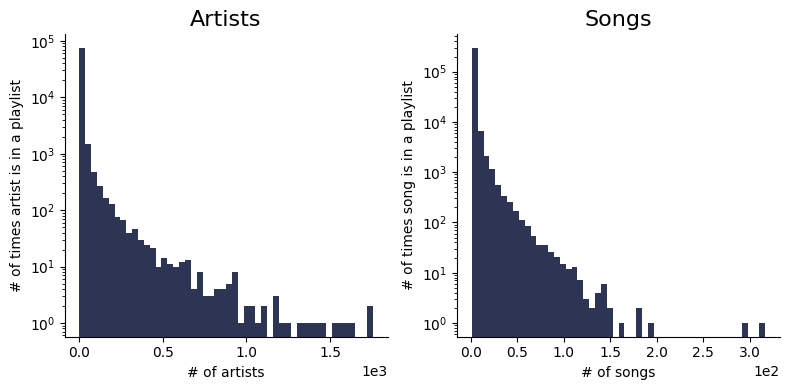

In [10]:
plot_distribution(artist_counter, song_counter)

#### Since it looks like our data is very skewed, we can use the `powerlaw` library and formally compare the distribution of how artists are represented in playlists to a powerlaw. 

#### `Purpose:` To formally compare the distribution of how artists are represented in playlists to a power law distribution.

In [11]:
data = list(artist_counter.values())
fit = powerlaw.Fit(data, discrete=True)

Calculating best minimal value for power law fit


#### `Interpretation of the Plot`
The plot helps to visualize how well the distribution of artist occurrences in playlists fits a power law. If the data follows a power law, the solid line (data) and the dashed line (fit) will align closely on the log-log plot. This indicates that a **small number of artists appear very frequently, while most artists appear much less frequently**, which is a common characteristic in many natural and social phenomena.

Calculating best minimal value for power law fit

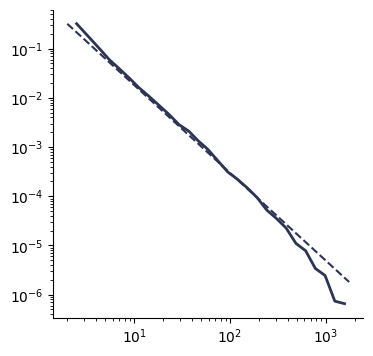

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
data = list(artist_counter.values())
fit = powerlaw.Fit(data, discrete=True)
figCCDF = fit.plot_pdf(color='#2E3454', linewidth=2, ax=ax)
fit.power_law.plot_pdf(color='#2E3454', linestyle='--', ax=figCCDF)
plt.show()

### Next step should be able to check to filter out the Noise form the Dataset

##### Benefits ? Lookout Below

<div>
<img src="static/filtering_wordcloud_2.png"> </img>
</div>

##### **Reason for Filtering**

**Data Quality and Relevance**:

**Focus on Popular Artists:** By keeping only artists with a frequency higher than 50, the system focuses on artists who are more popular or have a substantial amount of data. This helps in building a more robust and reliable recommender system.

In [13]:
df_playlist_modified = df_playlist_modified.groupby('artist').filter(lambda x : len(x)>=50)

#####  we should make sure to have as much unique information as possible for indivisual users to avoid the **Cold Start problem** 

##### let's keep the users with at least 10 unique artists in their playlists to lessen the impact of cold start problem¶


In [14]:
df_playlist_modified = df_playlist_modified[df_playlist_modified.groupby('user_id').artist.transform('nunique') >= 10]

In [15]:
df_playlist_modified

user_id                  artist  \
6       07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
7       07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
9       07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
10      07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
11      07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
...                                  ...                     ...   
644568  488ead471813ae982119153f792e4a3e  Florence + The Machine   
644569  488ead471813ae982119153f792e4a3e                  RuPaul   
644570  488ead471813ae982119153f792e4a3e                  Avicii   
644571  488ead471813ae982119153f792e4a3e          Tegan And Sara   
644574  488ead471813ae982119153f792e4a3e           Calvin Harris   

                                                    track    playlist  
6       Black Sands - Duke Dumont's 'Grains Of Sand' R...   Chill out  
7                                            Nothing Owed   Chill out  
9                                                 Emotion  Daft Punk   
10                                                   Fall  Daft Punk   
11                                            Rock'n Roll  Daft Punk   
...                                                   ...         ...  
644568                                       Shake It Out     Starred  
644569                                    Sissy That Walk     Starred  
644570                                           The Days     Starred  
644571                                          The Ocean     Starred  
644574                                      Under Control     Starred  

[318699 rows x 4 columns]

##### Watch out there is not column as unique identifier, so we need to create a new row_id column as the **row_number**

In [16]:
# add a row id
df_playlist_modified.insert(0, "row_id", range(0, len(df_playlist_modified)))

In [17]:
df_playlist_modified

row_id                           user_id                  artist  \
6            0  07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
7            1  07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
9            2  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
10           3  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
11           4  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
...        ...                               ...                     ...   
644568  318694  488ead471813ae982119153f792e4a3e  Florence + The Machine   
644569  318695  488ead471813ae982119153f792e4a3e                  RuPaul   
644570  318696  488ead471813ae982119153f792e4a3e                  Avicii   
644571  318697  488ead471813ae982119153f792e4a3e          Tegan And Sara   
644574  318698  488ead471813ae982119153f792e4a3e           Calvin Harris   

                                                    track    playlist  
6       Black Sands - Duke Dumont's 'Grains Of Sand' R...   Chill out  
7                                            Nothing Owed   Chill out  
9                                                 Emotion  Daft Punk   
10                                                   Fall  Daft Punk   
11                                            Rock'n Roll  Daft Punk   
...                                                   ...         ...  
644568                                       Shake It Out     Starred  
644569                                    Sissy That Walk     Starred  
644570                                           The Days     Starred  
644571                                          The Ocean     Starred  
644574                                      Under Control     Starred  

[318699 rows x 5 columns]

## Data Pre-peration

##### 1. **Creating new columns:** The 'playlist_id' and 'track_id' columns are created by concatenating existing columns. These new columns will serve as unique identifiers for playlists and tracks, which will be useful when making recommendations.

In [18]:
# Create new columns
df_playlist_modified['playlist_id'] = df_playlist_modified['user_id'] + '-' + df_playlist_modified['playlist']
df_playlist_modified['track_id'] = df_playlist_modified['artist'] + '|||' + df_playlist_modified['track']

In [19]:
# Create new columns
df_playlist_modified

row_id                           user_id                  artist  \
6            0  07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
7            1  07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
9            2  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
10           3  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
11           4  07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
...        ...                               ...                     ...   
644568  318694  488ead471813ae982119153f792e4a3e  Florence + The Machine   
644569  318695  488ead471813ae982119153f792e4a3e                  RuPaul   
644570  318696  488ead471813ae982119153f792e4a3e                  Avicii   
644571  318697  488ead471813ae982119153f792e4a3e          Tegan And Sara   
644574  318698  488ead471813ae982119153f792e4a3e           Calvin Harris   

                                                    track    playlist  \
6       Black Sands - Duke Dumont's 'Grains Of Sand' R...   Chill out   
7                                            Nothing Owed   Chill out   
9                                                 Emotion  Daft Punk    
10                                                   Fall  Daft Punk    
11                                            Rock'n Roll  Daft Punk    
...                                                   ...         ...   
644568                                       Shake It Out     Starred   
644569                                    Sissy That Walk     Starred   
644570                                           The Days     Starred   
644571                                          The Ocean     Starred   
644574                                      Under Control     Starred   

                                        playlist_id  \
6        07f0fc3be95dcd878966b1f9572ff670-Chill out   
7        07f0fc3be95dcd878966b1f9572ff670-Chill out   
9       07f0fc3be95dcd878966b1f9572ff670-Daft Punk    
10      07f0fc3be95dcd878966b1f9572ff670-Daft Punk    
11      07f0fc3be95dcd878966b1f9572ff670-Daft Punk    
...                                             ...   
644568     488ead471813ae982119153f792e4a3e-Starred   
644569     488ead471813ae982119153f792e4a3e-Starred   
644570     488ead471813ae982119153f792e4a3e-Starred   
644571     488ead471813ae982119153f792e4a3e-Starred   
644574     488ead471813ae982119153f792e4a3e-Starred   

                                                 track_id  
6       Bonobo|||Black Sands - Duke Dumont's 'Grains O...  
7                                   Bonobo|||Nothing Owed  
9                                     Daft Punk|||Emotion  
10                                       Daft Punk|||Fall  
11                                Daft Punk|||Rock'n Roll  
...                                                   ...  
644568              Florence + The Machine|||Shake It Out  
644569                           RuPaul|||Sissy That Walk  
644570                                  Avicii|||The Days  
644571                         Tegan And Sara|||The Ocean  
644574                      Calvin Harris|||Under Control  

[318699 rows x 7 columns]

In [20]:
len(df_playlist_modified)

318699

#### 3. **Creating sequences:** This is where the magic happens for a recommender system. For each playlist, you’re creating a sequence of artists and tracks. These sequences will be the input to your recommender system.

In [21]:
# Prepare dataset
df_playlist_modified = df_playlist_modified.groupby('playlist_id').agg(
    artist_sequence=('artist', lambda x: list(x)),
    track_sequence=('track_id', lambda x: list(x)),
    track_test_x=('track_id', lambda x: list(x)[:-1] if len(x) > 1 else []),
    track_test_y=('track_id', lambda x: list(x)[-1] if len(x) > 1 else '')
).reset_index()


In [22]:
df_playlist_modified 

playlist_id  \
0                000c11a16c89aa4b14b328080f5954ee-2000's   
1                 000c11a16c89aa4b14b328080f5954ee-Bashi   
2          000c11a16c89aa4b14b328080f5954ee-Drexler 2014   
3      000c11a16c89aa4b14b328080f5954ee-Liked from Radio   
4      000c11a16c89aa4b14b328080f5954ee-London Philha...   
...                                                  ...   
76578  fff616055993498d6127f3f467cf9f2b-natural eleme...   
76579  fff616055993498d6127f3f467cf9f2b-s u m m e r n...   
76580       fff616055993498d6127f3f467cf9f2b-sunday alt.   
76581  fff616055993498d6127f3f467cf9f2b-uneducated ha...   
76582  fff77dadf8528083c920b9c018847e8b-Liked from Radio   

                                         artist_sequence  \
0                                       [Tegan And Sara]   
1                                                  [RAC]   
2                                        [Jorge Drexler]   
3      [Frank Sinatra, Aterciopelados, Ben Howard, On...   
4                        [London Philharmonic Orchestra]   
...                                                  ...   
76578                                         [Coldplay]   
76579                          [Dirty Heads, Chet Faker]   
76580  [Noah And The Whale, Franz Ferdinand, Iron & W...   
76581           [Flo Rida, Fergie, The Notorious B.I.G.]   
76582  [Coldplay, Mat Kearney, Dashboard Confessional...   

                                          track_sequence  \
0           [Tegan And Sara|||I Couldn't Be Your Friend]   
1                                   [RAC|||Hard To Hold]   
2                      [Jorge Drexler|||Las transeuntes]   
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
4      [London Philharmonic Orchestra|||Concerto in D...   
...                                                  ...   
76578                   [Coldplay|||A Sky Full of Stars]   
76579  [Dirty Heads|||Lay Me Down (feat. Rome of Subl...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                            track_test_x  \
0                                                     []   
1                                                     []   
2                                                     []   
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
4                                                     []   
...                                                  ...   
76578                                                 []   
76579  [Dirty Heads|||Lay Me Down (feat. Rome of Subl...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                      track_test_y  
0                                                   
1                                                   
2                                                   
3         Billy Joel|||Movin' Out (Anthony's Song)  
4                                                   
...                                            ...  
76578                                               
76579                      Chet Faker|||No Diggity  
76580             Of Monsters and Men|||Your Bones  
76581             The Notorious B.I.G.|||Hypnotize  
76582  Thirty Seconds To Mars|||The Kill (Bury Me)  

[76583 rows x 5 columns]

#### 4. **Filtering out groups with less than 3 tracks:** Playlists with less than 3 tracks are filtered out because they don’t provide enough information for the recommender system to learn from.

In [23]:
df_playlist_modified = df_playlist_modified[df_playlist_modified['track_sequence'].apply(len) > 2]

In [24]:
df_playlist_modified

playlist_id  \
3      000c11a16c89aa4b14b328080f5954ee-Liked from Radio   
13     00123e0f544dee3ab006aa7f1e5725a7-ALL ROCK ARTI...   
14          00123e0f544dee3ab006aa7f1e5725a7-Andrew Bird   
15           00123e0f544dee3ab006aa7f1e5725a7-Bass stuff   
16                 00123e0f544dee3ab006aa7f1e5725a7-Cake   
...                                                  ...   
76576      fff616055993498d6127f3f467cf9f2b-liquid beats   
76577    fff616055993498d6127f3f467cf9f2b-m o r n i n g    
76580       fff616055993498d6127f3f467cf9f2b-sunday alt.   
76581  fff616055993498d6127f3f467cf9f2b-uneducated ha...   
76582  fff77dadf8528083c920b9c018847e8b-Liked from Radio   

                                         artist_sequence  \
3      [Frank Sinatra, Aterciopelados, Ben Howard, On...   
13     [Neil Young, Wilco, Jethro Tull, Joni Mitchell...   
14     [Andrew Bird, Andrew Bird, Andrew Bird, Andrew...   
15     [Hot Tuna, Hot Tuna, Hot Tuna, Hot Tuna, Hot T...   
16     [Cake, Cake, Cake, Cake, Cake, Cake, Cake, Cak...   
...                                                  ...   
76576          [CAZZETTE, Calvin Harris, Above & Beyond]   
76577  [Damien Rice, James Bay, James Blake, James Bl...   
76580  [Noah And The Whale, Franz Ferdinand, Iron & W...   
76581           [Flo Rida, Fergie, The Notorious B.I.G.]   
76582  [Coldplay, Mat Kearney, Dashboard Confessional...   

                                          track_sequence  \
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
13     [Neil Young|||(Emcee Intro) - Live - Canterbur...   
14     [Andrew Bird|||Belles, Andrew Bird|||Oh Baltim...   
15     [Hot Tuna|||Barbeque King, Hot Tuna|||Been So ...   
16     [Cake|||Alpha Beta Parking Lot, Cake|||Cool Bl...   
...                                                  ...   
76576  [CAZZETTE|||Blind Heart - Radio Edit, Calvin H...   
76577  [Damien Rice|||Delicate, James Bay|||Let It Go...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                            track_test_x  \
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
13     [Neil Young|||(Emcee Intro) - Live - Canterbur...   
14     [Andrew Bird|||Belles, Andrew Bird|||Oh Baltim...   
15     [Hot Tuna|||Barbeque King, Hot Tuna|||Been So ...   
16     [Cake|||Alpha Beta Parking Lot, Cake|||Cool Bl...   
...                                                  ...   
76576  [CAZZETTE|||Blind Heart - Radio Edit, Calvin H...   
76577  [Damien Rice|||Delicate, James Bay|||Let It Go...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                      track_test_y  
3         Billy Joel|||Movin' Out (Anthony's Song)  
13                   The Kinks|||You Really Got Me  
14                              Andrew Bird|||Why?  
15            Hot Tuna|||Watch The North Wind Rise  
16                           Cake|||The Guitar Man  
...                                            ...  
76576                  Above & Beyond|||Sun & Moon  
76577                   James Blake|||Measurements  
76580             Of Monsters and Men|||Your Bones  
76581             The Notorious B.I.G.|||Hypnotize  
76582  Thirty Seconds To Mars|||The Kill (Bury Me)  

[27817 rows x 5 columns]

In [25]:
# Clean track_test_x sequences by removing NaN values
df_playlist_modified['track_test_x'] = df_playlist_modified['track_test_x'].apply(lambda x: [i for i in x if pd.notna(i)])
df_playlist_modified['track_test_y'] = df_playlist_modified['track_test_y'].apply(lambda x: x if pd.notna(x) else '')

C:\Users\User\AppData\Local\Temp\ipykernel_1920\4033885385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_playlist_modified['track_test_x'] = df_playlist_modified['track_test_x'].apply(lambda x: [i for i in x if pd.notna(i)])
C:\Users\User\AppData\Local\Temp\ipykernel_1920\4033885385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_playlist_modified['track_test_y'] = df_playlist_modified['track_test_y'].apply(lambda x: x if pd.notna(x) else '')


In [26]:
df_playlist_modified

playlist_id  \
3      000c11a16c89aa4b14b328080f5954ee-Liked from Radio   
13     00123e0f544dee3ab006aa7f1e5725a7-ALL ROCK ARTI...   
14          00123e0f544dee3ab006aa7f1e5725a7-Andrew Bird   
15           00123e0f544dee3ab006aa7f1e5725a7-Bass stuff   
16                 00123e0f544dee3ab006aa7f1e5725a7-Cake   
...                                                  ...   
76576      fff616055993498d6127f3f467cf9f2b-liquid beats   
76577    fff616055993498d6127f3f467cf9f2b-m o r n i n g    
76580       fff616055993498d6127f3f467cf9f2b-sunday alt.   
76581  fff616055993498d6127f3f467cf9f2b-uneducated ha...   
76582  fff77dadf8528083c920b9c018847e8b-Liked from Radio   

                                         artist_sequence  \
3      [Frank Sinatra, Aterciopelados, Ben Howard, On...   
13     [Neil Young, Wilco, Jethro Tull, Joni Mitchell...   
14     [Andrew Bird, Andrew Bird, Andrew Bird, Andrew...   
15     [Hot Tuna, Hot Tuna, Hot Tuna, Hot Tuna, Hot T...   
16     [Cake, Cake, Cake, Cake, Cake, Cake, Cake, Cak...   
...                                                  ...   
76576          [CAZZETTE, Calvin Harris, Above & Beyond]   
76577  [Damien Rice, James Bay, James Blake, James Bl...   
76580  [Noah And The Whale, Franz Ferdinand, Iron & W...   
76581           [Flo Rida, Fergie, The Notorious B.I.G.]   
76582  [Coldplay, Mat Kearney, Dashboard Confessional...   

                                          track_sequence  \
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
13     [Neil Young|||(Emcee Intro) - Live - Canterbur...   
14     [Andrew Bird|||Belles, Andrew Bird|||Oh Baltim...   
15     [Hot Tuna|||Barbeque King, Hot Tuna|||Been So ...   
16     [Cake|||Alpha Beta Parking Lot, Cake|||Cool Bl...   
...                                                  ...   
76576  [CAZZETTE|||Blind Heart - Radio Edit, Calvin H...   
76577  [Damien Rice|||Delicate, James Bay|||Let It Go...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                            track_test_x  \
3      [Frank Sinatra|||Come Fly With Me - 1998 Digit...   
13     [Neil Young|||(Emcee Intro) - Live - Canterbur...   
14     [Andrew Bird|||Belles, Andrew Bird|||Oh Baltim...   
15     [Hot Tuna|||Barbeque King, Hot Tuna|||Been So ...   
16     [Cake|||Alpha Beta Parking Lot, Cake|||Cool Bl...   
...                                                  ...   
76576  [CAZZETTE|||Blind Heart - Radio Edit, Calvin H...   
76577  [Damien Rice|||Delicate, James Bay|||Let It Go...   
76580  [Noah And The Whale|||2 Atoms In A Molecule, F...   
76581  [Flo Rida|||Club Can't Handle Me - feat. David...   
76582  [Coldplay|||42, Mat Kearney|||All I Have, Dash...   

                                      track_test_y  
3         Billy Joel|||Movin' Out (Anthony's Song)  
13                   The Kinks|||You Really Got Me  
14                              Andrew Bird|||Why?  
15            Hot Tuna|||Watch The North Wind Rise  
16                           Cake|||The Guitar Man  
...                                            ...  
76576                  Above & Beyond|||Sun & Moon  
76577                   James Blake|||Measurements  
76580             Of Monsters and Men|||Your Bones  
76581             The Notorious B.I.G.|||Hypnotize  
76582  Thirty Seconds To Mars|||The Kill (Bury Me)  

[27817 rows x 5 columns]

In [27]:
# Prepare dataset
def listify(x):
    return list(x) if isinstance(x, list) else []

In [28]:
# Ensure no NaN values in track_test_x and track_test_y
df_playlist_modified['track_test_x'] = df_playlist_modified['track_test_x'].apply(listify)
df_playlist_modified = df_playlist_modified.dropna(subset=['track_test_x', 'track_test_y'])
grouped = df_playlist_modified[df_playlist_modified['track_test_x'].map(len) > 0]
grouped = grouped[grouped['track_test_y'] != '']

C:\Users\User\AppData\Local\Temp\ipykernel_1920\3430080776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_playlist_modified['track_test_x'] = df_playlist_modified['track_test_x'].apply(listify)


#### 5. **Creating the test set:** The last track in each sequence is used as the test set. The recommender system will try to predict this track based on the rest of the sequence.

#### 6. **Splitting the data into train, validate, and test sets:** Finally, the data is split into training, validation, and testing sets. The training set is used to train the recommender system, the validation set is used to tune parameters and the test set is used to evaluate the final model.

In [29]:
train, validate, test = np.split(grouped.sample(frac=1, random_state=42), [int(0.7 * len(grouped)), int(0.9 * len(grouped))])
print("# testing rows:", len(test))

# testing rows: 2782


d:\recom\recom_env\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Model Training

#### 1. Define hyperparameters ** Build the vocabulary ** train the model

`min_count:` This parameter specifies the minimum frequency of a word in the corpus (collection of all tracks) for it to be included in the Word2Vec model. Words with frequencies lower than this threshold will be ignored. In this configuration, min_count is set to 10, meaning that only tracks that appear at least 10 times in the dataset will be considered.

`epochs:` Epochs refer to the number of iterations (passes) over the entire dataset during training. Each iteration involves updating the model's parameters based on the training data. Setting epochs to 30 means that the model will iterate over the dataset 30 times during training, adjusting its parameters to better capture the underlying patterns in the data.

`vector_size:` This parameter determines the dimensionality of the word vectors (embeddings) learned by the Word2Vec model. Each track in the dataset will be represented as a dense vector of this size. In this configuration, vector_size is set to 48, meaning that each track will be embedded into a 48-dimensional vector space.

`window:` The window parameter defines the maximum distance between the current and predicted track within a track sequence. It essentially sets the context window size for the Word2Vec model. A larger window allows the model to capture more global context, while a smaller window focuses on local context. Here, window is set to 10, meaning that the model considers the 10 surrounding tracks when predicting the next track in a sequence.

`ns_exponent:` This parameter controls the sampling distribution for negative sampling, which is a technique used to train Word2Vec models more efficiently by only updating a small subset of word vectors in each training iteration. The ns_exponent determines the exponent of the sampling distribution. A value closer to 0.0 will prioritize more frequent words for negative sampling, while a value closer to 1.0 will give more uniform sampling. In this configuration, ns_exponent is set to 0.75.

In [30]:
# Training the Word2Vec model
hyperparams = {
    "min_count": 3,
    "epochs": 30,
    "vector_size": 48,
    "window": 10,
    "ns_exponent": 0.75,
}
track2vec_model = Word2Vec(**hyperparams)
track2vec_model = Word2Vec(min_count=1)

# Assuming `train['track_sequence']` is a list of lists where each sublist is a sequence of tracks
track_sequences = train['track_sequence'].tolist()  # Ensure it's a list of lists

print(track_sequences)

# Build the vocabulary
track2vec_model.build_vocab(track_sequences)

# Train the Word2Vec model
track2vec_model.train(track_sequences, total_examples=track2vec_model.corpus_count, epochs=track2vec_model.epochs)
print("Training completed!")
print(f"Vector space size: {len(track2vec_model.wv.index_to_key)}")

[['Weezer|||Butterfly', 'Foo Fighters|||Everlong', 'Purity Ring|||Grandloves', 'Weezer|||Tired Of Sex'], ["Beastie Boys|||Boomin' Granny - Digitally Remastered 99", 'Beastie Boys|||Crazy A** S**t', 'Beastie Boys|||Lighten Up', "Beastie Boys|||Live At P.J.'s", 'Beastie Boys|||Namaste', 'Beastie Boys|||Off The Grid', 'Beastie Boys|||Root Down', "Beastie Boys|||So What'Cha Want", 'Beastie Boys|||Suco De Tangerina', 'Beastie Boys|||The Cousin Of Death', 'Beastie Boys|||The Lisa Lisa / Full Force Routine', 'Beastie Boys|||To All The Girls', 'Beastie Boys|||Twenty Questions - 1999 Digital Remaster', 'Beastie Boys|||What Comes Around'], ['Sonny Rollins|||Misterioso - 1999 Remaster', 'Django Reinhardt|||Out Of Nowhere', 'Thelonious Monk|||Ruby My Dear - 1998 - Remaster', 'Chick Corea|||Song Of The Wind', 'Sarah Vaughan|||You Go To My Head'], ['Stereophonics|||A Thousand Trees', 'Ben Folds Five|||Brick', "REO Speedwagon|||Can't Fight This Feeling", 'Elton John|||Candle In The Wind 1997', 'Skunk

#### 2. Define function to predict next track

The `predict_next_track` function takes in a vector space (Word2Vec model), a sequence of tracks, and a number k to generate k recommendations for the next track. It works by using the last track in the sequence to find the most similar tracks in the vector space. If the last track is not in the vector space, it selects a random track to ensure recommendations can still be made. The function returns a list of the most similar tracks to the query track, which can then be used as recommendations.

In [34]:
# Function to predict the next track
def predict_next_track(vector_space, input_sequence, k):
    query_item = input_sequence[-1]
    if query_item not in vector_space:
        query_item = choice(list(vector_space.index_to_key))
    return [_[0] for _ in vector_space.most_similar(query_item, topn=k)]


#### 3. Define function to evaluate model

The `evaluate_model` function processes a DataFrame of track sequences to generate next-track predictions using a pre-trained vector space model. It filters out invalid predictions, calculates the hit rate by comparing predictions to the actual next tracks, and returns this hit rate as a measure of model performance. This function helps in understanding how well the model is performing in making accurate music recommendations.

In [35]:
def evaluate_model(df, vector_space, k):
    # Ensure track_test_x is a list
    df['track_test_x'] = df['track_test_x'].apply(listify)
    
    # Drop rows where track_test_x is empty
    df = df[df['track_test_x'].map(len) > 0]

    pred = list(
        filter(
            lambda x: x[1] is not None,
            map(
                lambda idx, track_test_x: (
                    idx,
                    predict_next_track(vector_space, track_test_x, k)
                ),
                df['track_test_x'].index,
                df['track_test_x']
            )
        )
    )

    rows_to_keep = [idx for idx, _ in pred]

    # Filter the DataFrame to keep only rows without exceptions
    df = df.loc[rows_to_keep]

    df['predictions'] = [p[1] for p in pred]
    df['hit'] = df.apply(lambda row: 1 if row['track_test_y'] in row['predictions'] else 0, axis=1)
    hit_rate = df['hit'].sum() / len(df)
    return hit_rate


#### Model Evaluation

In [36]:
KNN_K = 100

In [37]:
# Validate the model
validation_metric = evaluate_model(validate, track2vec_model.wv, k=KNN_K)
print(f"Hit Rate@{KNN_K} on validation set: {validation_metric}")

# Test the model
test_metric = evaluate_model(test, track2vec_model.wv, k=KNN_K)
print(f"Hit Rate@{KNN_K} on test set:       {test_metric}")

Hit Rate@100 on validation set: 0.0008986340762041696
Hit Rate@100 on test set:       0.0003594536304816679


### HyperParameter Tuning

In [38]:
def evaluate_model(_df, vector_space, k):
    _df["predictions"] = _df["track_test_x"].apply(lambda x: predict_next_track(vector_space, x, k))
    _df["hit"] = _df.apply(lambda row: 1 if row["track_test_y"] in row["predictions"] else 0, axis=1)
    hit_rate = _df["hit"].sum() / len(_df)
    return hit_rate


In [39]:
def end():
    print("All done\n\n\n")

In [40]:
def model_testing(final_dataset, final_vectors, KNN_K):
    
    test_metric = evaluate_model(final_dataset, final_vectors, k=int(KNN_K))
    print("Hit Rate@{} on the test set is: {}".format(KNN_K, test_metric))
    end()

The `generate_embeddings` function trains a Word2Vec model using specified hyperparameters and a training dataset of track sequences. The function then evaluates the trained model using validation data and tests its performance on a test dataset. The key steps involved are

In [41]:
def generate_embeddings(hyper_string, train, validate, test, KNN_K):
    hypers = json.loads(hyper_string)
    
    track2vec_model = Word2Vec(train["track_sequence"], **hypers)
    print("Training with hypers {} is completed!".format(hyper_string))
    print("Vector space size: {}".format(len(track2vec_model.wv.index_to_key)))
    test_track = choice(list(track2vec_model.wv.index_to_key))
    print("Example track: '{}'".format(test_track))
    test_vector = track2vec_model.wv[test_track]
    print("Test vector for '{}': {}".format(test_track, test_vector[:5]))
    test_sims = track2vec_model.wv.most_similar(test_track, topn=3)
    print("Similar songs to '{}': {}".format(test_track, test_sims))
    validation_metric = evaluate_model(validate, track2vec_model.wv, k=int(KNN_K))
    print("Hit Rate@{} is: {}".format(KNN_K, validation_metric))
    track_vectors = track2vec_model.wv
    model_testing(test, track_vectors, KNN_K)

In [42]:
hypers_sets = [
    json.dumps(_)
    for _ in [
        {"min_count": 3, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75},
        {"min_count": 5, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75},
        {"min_count": 10, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75},
        {"min_count": 20, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75}
    ]
]
for hyper_set in hypers_sets:
    generate_embeddings(hyper_set, train, validate, test, KNN_K)

Training with hypers {"min_count": 3, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75} is completed!
Vector space size: 14886
Example track: 'Gorillaz|||19-2000'
Test vector for 'Gorillaz|||19-2000': [-0.06640762 -0.06245771  0.16063336  0.06133992  0.15180096]
Similar songs to 'Gorillaz|||19-2000': [('Dave Matthews Band|||Everyday', 0.9973819851875305), ('Mac Demarco|||Passing Out Pieces', 0.9970496296882629), ('The Black Keys|||Thickfreakness', 0.997043788433075)]
Hit Rate@100 is: 0.003235082674335011
Hit Rate@100 on the test set is: 0.006470165348670022
All done



Training with hypers {"min_count": 5, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75} is completed!
Vector space size: 5877
Example track: 'Calvin Harris|||Sweet Nothing'
Test vector for 'Calvin Harris|||Sweet Nothing': [-0.29174748 -0.05663656  0.2250179   0.260087    0.2818884 ]
Similar songs to 'Calvin Harris|||Sweet Nothing': [("Paramore|||That's What You Get", 0.998197615146637)

#### So the HyperParameter string = `{"min_count": 20, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75}` is the best performing

#### Let's build the model again with hyperparameter

In [43]:
def final_train_model(df, best_hyperparameters):
    """
    Train the model using the best hyperparameters.
    """
    track_sequence = df['track_sequence'].tolist()

    track2vec_model = Word2Vec(track_sequence, **best_hyperparameters)

    return track2vec_model

In [44]:
def final_predict_similar_tracks(track2vec_model, track_name, topn=3):
    """
    Predict similar tracks to a given track.
    """
    if track_name in track2vec_model.wv:
        similar_tracks = track2vec_model.wv.most_similar(track_name, topn=topn)
        return similar_tracks
    else:
        return None

In [49]:
best_hyperparameters = {"min_count": 20, "epochs": 30, "vector_size": 48, "window": 10, "ns_exponent": 0.75}

# Train the model
track2vec_model = final_train_model(df_playlist_modified, best_hyperparameters)

# Take input track name from user
input_track_name = input("Enter the track name: ")

# Predict similar tracks
similar_tracks = final_predict_similar_tracks(track2vec_model, input_track_name)

if similar_tracks:
    print("Similar songs to '{}':".format(input_track_name))
    for track, similarity in similar_tracks:
        print("{}: {}".format(track, similarity))
else:
    print("Track '{}' not found in the model.".format(input_track_name))

Similar songs to 'Calvin Harris|||Sweet Nothing':
Martin Garrix|||Animals: 0.989950954914093
Usher|||Scream: 0.9894099235534668
Don Omar|||Danza Kuduro: 0.9860481023788452
